<a href="https://colab.research.google.com/github/ishikaa25/IM_Estimation/blob/main/main_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimation of Induction Motor parameters
### *A comparison between **PSO** and **HPSO** (JTVAC) algorithms*.


First we import the neccessary libraries into this notebook

In [ ]:
import numpy as np
from root import Root
from numpy.random import uniform, normal, randint
from numpy import pi, sin, cos, zeros, minimum, maximum, abs, where, sign
from copy import deepcopy
import matplotlib.pyplot as plt

We now define the global variables or **name-plate details**


*   `V` - Rated voltage = 460 V
*   `f` - Frequency = 60 Hz
*   `s` - Full-load slip = 0.021
*   `P` - No. of poles = 4
*   `Tfl` - Full-load torque = 19.6730 N-m
*   `Tstart` - Starting torque = 119.2629 N-m
*   `Tmax`- Breakdown torque = 149.082 N-m
*   `pfl`- Full-load power factor = 0.89


We use the values given in the paper:

[Parameter Estimation of Three-Phase Induction Motor Using
Hybrid of Genetic Algorithm and Particle Swarm Optimization](https://https://downloads.hindawi.com/journals/je/2014/148204.pdf)

In [ ]:
V = 460/np.sqrt(3)
f = 60
s = 0.021
P = 4
ws = ((2*f)/P)*2*np.pi
Tfl = 19.6730
Tstart = 119.2629
Tmax = 149.082
pfl = 0.89

In [ ]:
# V = float(input('Voltage (line): '))/np.sqrt(3)
# f = float(input('Frequency: '))
# s = float(input('Full load slip: '))
# P = float(input('No. of poles: '))
# Tn = float(input('Full-load torque: '))
# Ts = float(input('Starting torque: '))
# Tbd = float(input('Breakdown torque: '))
# pfl = float(input('Full load power factor: '))

# #Synchronous speed (in radians)
# ws = ((2*f)/P)*2*np.pi

### Defining a custom fitness function

The decision variables are as follows:

*   `Rs` - Stator resistance
*   `Rrd` - Rotor resistance referred at stator side
*   `Xs` - Stator leakage reactance (= Xlr' - )
*   `Xm` - Magnetizing reactance 

**Note:** 
The value of rotor leakage reactance referred at stator side is assumed to be equal to stator leakage reactance. Thus, to represent it we can use the same variable `Xs`.

*Reference*: [Parameter Estimation of Three-Phase Induction Motor Using
Hybrid of Genetic Algorithm and Particle Swarm Optimization](https://https://downloads.hindawi.com/journals/je/2014/148204.pdf)

In [ ]:
def fitness(x):
  
  Rs = x[0]
  Rrd = x[1]
  Xs = x[2]
  Xm  = x[3]

  Vth = V*(Xm)/(Xs+Xm)
  Rth = Rs*(Xm)/(Xs+Xm)
  Xth = Xs*(Xm)/(Xs+Xm)
  k = 3*(Vth**2)/ws
  pf = np.cos(np.arctan((Xth+Xs)/(Rth+(Rrd/s))))
 
  f1 = k*(Rrd/s)/((Rth+(Rrd/s))**2 + (Xth+Xs)**2) - Tfl
  f2 = (k*Rrd)/((Rth+Rrd)**2+(Xth+Xs)**2) - Tstart
  f3 = (k/2)*(1/((Rth+np.sqrt(Rth**2+(Xth+Xs)**2)))) - Tmax
  f4 = (pf - pfl)/pfl

  F = (f1/Tfl)**2 + (f2/Tstart)**2 + (f3/Tmax)**2 + (f4)**2 

  return F

### Defining classes for running the algorithms: 
(inherited by class `Root`)


*   `BasePSO`    - Particle Swarm Optimization (Vanilla) - 
[[Reference]](https://https://arxiv.org/ftp/arxiv/papers/1804/1804.05319.pdf)
*   `HPSO_JTVAC` - Hierarchial PSO with jumping time-varying acceleration coefficients [[Reference]](https://ietresearch.onlinelibrary.wiley.com/doi/epdf/10.1049/el.2017.2112)



In [ ]:
class BasePSO(Root):
    """
    Performs Particle Swarm Optimization
    
    Parameters to initialize object:
    fitness   - Function (object): Fitness function (to minimize)
    lb        - list (float or int): Lower bound
    ub        - list (float or int): Upper bound
    verbose   - bool: To print fitness value after every iteration
    epoch     - int: Number of iteration
    pop_size  - int: Population size
    """

    def __init__(self, obj_func=None, lb=None, ub=None, verbose=True, epoch=750, pop_size=100,c1=1.2, c2=1.2, w_min=0.4, w_max=0.9, **kwargs):
        Root.__init__(self, obj_func, lb, ub, verbose, kwargs)
        self.epoch = epoch
        self.pop_size = pop_size
        self.c1 = c1            # [0-2]  -> [(1.2, 1.2), (0.8, 2.0), (1.6, 0.6)]  Local and global coefficient
        self.c2 = c2
        self.w_min = w_min      # [0-1] -> [0.4-0.9]      Weight of bird
        self.w_max = w_max

    def train(self):
        pop = [self.create_solution() for _ in range(self.pop_size)]
        v_max = 0.5 * (self.ub - self.lb)
        v_min = zeros(self.problem_size)
        v_list = uniform(v_min, v_max, (self.pop_size, self.problem_size))
        pop_local = deepcopy(pop)
        g_best = self.get_global_best_solution(pop=pop, id_fit=self.ID_FIT, id_best=self.ID_MIN_PROB)

        for epoch in range(self.epoch):
            # Update weight after each move count  (weight down)
            w = (self.epoch - epoch) / self.epoch * (self.w_max - self.w_min) + self.w_min
            for i in range(self.pop_size):
                v_new = w * v_list[i] + self.c1 * uniform() * (pop_local[i][self.ID_POS] - pop[i][self.ID_POS]) +\
                            self.c2 * uniform() * (g_best[self.ID_POS] - pop[i][self.ID_POS])
                x_new = pop[i][self.ID_POS] + v_new             # Xi(new) = Xi(old) + Vi(new) * deltaT (deltaT = 1)
                x_new = self.amend_position_random_faster(x_new)
                fit_new = self.get_fitness_position(x_new)
                pop[i] = [x_new, fit_new]

                # Update current position, current velocity and compare with past position, past fitness (local best)
                if fit_new < pop_local[i][self.ID_FIT]:
                    pop_local[i] = [x_new, fit_new]

                ## batch size idea
                if self.batch_idea:
                    if (i + 1) % self.batch_size == 0:
                        g_best = self.update_global_best_solution(pop_local, self.ID_MIN_PROB, g_best)
                else:
                    if (i + 1) % self.pop_size:
                        g_best = self.update_global_best_solution(pop_local, self.ID_MIN_PROB, g_best)
            self.loss_train.append(g_best[self.ID_FIT])
            if self.verbose:
                print(">> Epoch: {}, Best fit: {}".format(epoch+1, g_best[self.ID_FIT]))
        self.solution = g_best
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train


class HPSO_JTVAC(Root):
    """
    Performs Hierarchical PSO with jumping time-varying acceleration coefficients
    
    Parameters to initialize object:
    fitness   - Function (object): Fitness function (to minimize)
    lb        - list (float or int): Lower bound
    ub        - list (float or int): Upper bound
    verbose   - bool: To print fitness value after every iteration
    epoch     - int: Number of iteration
    pop_size  - int: Population size

    """

    def __init__(self, obj_func=None, lb=None, ub=None, verbose=True, epoch=750, pop_size=100, ci=0.5, cf=0.0, **kwargs):
        Root.__init__(self, obj_func, lb, ub, verbose, kwargs)
        self.epoch = epoch
        self.pop_size = pop_size
        self.ci = ci
        self.cf = cf

    def train(self):
        '''
        Trains the decision variables on the HPSO_JTVAC
        '''
        # Initialization
        v_max = 0.5 * (self.ub - self.lb)
        v_list = zeros((self.pop_size, self.problem_size))

        pop = [self.create_solution() for _ in range(self.pop_size)]
        pop_local = deepcopy(pop)
        g_best = self.get_global_best_solution(pop=pop, id_fit=self.ID_FIT, id_best=self.ID_MIN_PROB)
        
        ##################
        for epoch in range(0, self.epoch):
            c_it = ((self.cf - self.ci) * ((epoch+1) / self.epoch)) + self.ci   #updating acceleration coefficients as in HPSO_TVAC

            for i in range(0, self.pop_size):
                idx_k = randint(0, self.pop_size)
                w = normal()
                while(abs(w - 1.0) < 0.01):
                    w = normal()
                #Updating acceleration coefficients as in HPSO_JVAC
                c1_it = abs(w) ** (c_it * w)
                c2_it = abs(1 - w) ** (c_it / (1 - w))

                # HPSO main
                v_list[i] = c1_it * uniform(0, 1, self.problem_size) * (pop_local[i][self.ID_POS] - pop[i][self.ID_POS]) + \
                    c2_it * uniform(0, 1, self.problem_size) * (g_best[self.ID_POS] + pop_local[idx_k][self.ID_POS] - 2*pop[i][self.ID_POS])

                where(v_list[i] == 0, sign(0.5-uniform()) * uniform() * v_max, v_list[i])
                v_list[i] = sign(v_list[i]) * minimum(abs(v_list[i]), v_max)
                #########################

                v_list[i] = minimum(maximum(v_list[i], -v_max), v_max)
                x_temp = pop[i][self.ID_POS] + v_list[i]
                x_temp = minimum(maximum(x_temp, self.lb), self.ub)
                fit = self.get_fitness_position(x_temp)
                pop[i] = [x_temp, fit]

                if fit < pop_local[i][self.ID_FIT]:
                    pop_local[i] = [x_temp, fit]

                ## batch size idea
                if self.batch_idea:
                    if (i + 1) % self.batch_size == 0:
                        g_best = self.update_global_best_solution(pop_local, self.ID_MIN_PROB, g_best)
                else:
                    if (i + 1) % self.pop_size:
                        g_best = self.update_global_best_solution(pop_local, self.ID_MIN_PROB, g_best)
            self.loss_train.append(g_best[self.ID_FIT])
            if self.verbose:
                print(">> Epoch: {}, Best fit: {}".format(epoch + 1, g_best[self.ID_FIT]))
        self.solution = g_best
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train

## Optimization

Setting-up hyperparameters and bounds (wrt actual values)

**Note:** Variable `actual` denotes the original/calculated values of the decision parameters

In [ ]:
verbose = False
epoch = 100
pop_size = 100
actual = np.array([1.115,1.083,1.126,38.4])
lb = [1, 1, 1, 20]
ub = [5, 5, 5, 50]

#### **PSO results:**


In [ ]:
np.random.seed(2)
md1 = BasePSO(fitness, lb, ub, verbose, epoch, pop_size)
best_pos1, best_fit1, list_loss1 = md1.train()
print("Best cost: {}, \nBest values: {}".format(md1.solution[1],best_pos1))

Best cost: 0.01532165910717898, 
Best values: [ 1.24554043  1.07031541  1.04445385 33.18361298]


#### **HPSO (JTVAC) Results:**

In [ ]:
np.random.seed(3)
md2 = HPSO_JTVAC(fitness, lb, ub, False,epoch, pop_size)
best_pos2, best_fit2, list_loss2 = md2.train()
print("Best cost: {}, \nBest values: {}".format(md2.solution[1],best_pos2))

Best cost: 0.015029360003279906, 
Best values: [ 1.10606835  1.08089107  1.12869809 36.99537011]


# Error and comparison

Defining a class `Plots` to plot all the neccessary graphs

In [ ]:
class Plots():

  def parameters(self,params):

    s = np.array((range(1,1000,1)))/1000
    s = np.append(s,1)

    sfl = np.array((range(1,21,1)))/1000
    Rs, Rrd, Xs, Xm = params

    Vth = V*(Xm)/(Xs+Xm)
    Rth = Rs*(Xm)/(Xs+Xm)
    Xth = Xs*(Xm)/(Xs+Xm)
    k = 3*(Vth**2)/ws

    Te = k*(Rrd/s)/((Rth+(Rrd/s))**2 + (Xth+Xs)**2)


    #Stator current
    Zr = np.divide(Rrd,sfl) + (Xs) * 1j
    Zs = Rs + Xs*1j      #since Xr'= Xs (assumption)
    Xm_im = Xm*1j
    Znet = Zs + (Zr*Xm_im)/(Zr+Xm_im)
    Is = (V/Znet)

    #pf
    pf = np.cos(np.angle(Is))

    #Eff
    Z = (Rth+(Rrd/sfl)) + (Xth+Xs)*1j
    I = Vth/Z
    Pin = Vth*np.abs(Is)*pf
    Pout = (np.abs(I)**2)*Rrd*np.divide(1-sfl,sfl)
    eff = (Pout/Pin)*100

    Is = np.abs(Is)

    return (Te,eff,Pout,Is,pf)


  def cost_comparison(self,cost1,cost2):
    '''
    Plots graphs side-by-side for both algorithms

    Parameters:
    cost1 - list/numpy array : Cost values of each iteration of PSO
    cost2 - list/numpy array : Cost values of each iteration of HPSO_JTVAC
    '''
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    fig.tight_layout(pad=10)
    ax[0].set(title='Convergence of PSO',xlabel='No. of Iterations',ylabel='Cost')
    ax[0].plot(list_loss1,'m')
    ax[1].set(title='Convergence of HPSO-JTVAC',xlabel='No. of Iterations',ylabel='Cost')
    ax[1].plot(list_loss2,'r')
    plt.show();

  def performance(self,actual,sol1,sol2):
    Te,eff,Pout,Is,pf = self.parameters(actual)
    Te1,eff1,Pout1,Is1,pf1  = self.parameters(sol1)
    Te2,eff2,Pout2,Is2,pf2  = self.parameters(sol2)

    self.slip_torque(Te,Te1,Te2)
    self.efficiency(Pout,eff,Pout1,eff1,Pout2,eff2)
    self.current(Pout,Is,Pout1,Is1,Pout2,Is2)
    self.power_factor(Pout,pf,Pout1,pf1,Pout2,pf2)

  def slip_torque(self,Te,Te1,Te2):
    s = np.array((range(1,1000,1)))/1000
    s = np.append(s,1)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    fig.tight_layout(pad=10)
    fig.suptitle('\n\nComparison of Slip-Torque characteristics', fontsize=17)

    #PSO-Te
    ax[0].plot(s,Te,'b--')
    ax[0].plot(s,Te1,'r')
    ax[0].invert_xaxis()
    ax[0].legend(['Original','PSO'])
    ax[0].set(title='Electrical torque vs Slip',xlabel='Slip (s)',ylabel='Electrical torque (Te)')

    #HPSO_JTVAC-Te
    ax[1].plot(s,Te,'b--')
    ax[1].plot(s,Te2,'r')
    ax[1].invert_xaxis()
    ax[1].legend(['Original','HPSO-JTVAC'])
    ax[1].set(title='Electrical torque vs Slip',xlabel='Slip (s)',ylabel='Electrical torque (Te)')


  def efficiency(self,Pout,eff,Pout1,eff1,Pout2,eff2):

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    fig.tight_layout(pad=10)
    fig.suptitle('\n\nComparison of Efficiency characteristics', fontsize=17)

    #PSO-eff
    ax[0].plot(Pout,eff,'b--')
    ax[0].plot(Pout1,eff1,'r')
    ax[0].legend(['Original','PSO'])
    ax[0].set(title='Efficiency vs Output Power',xlabel='Output Power (W)',ylabel='Efficiency (%)')

    #HPSO_JTVAC-eff
    ax[1].plot(Pout,eff,'b--')
    ax[1].plot(Pout2,eff2,'r')
    ax[1].legend(['Original','HPSO-JTVAC'])
    ax[1].set(title='Efficiency vs Output Power',xlabel='Output Power (W)',ylabel='Efficiency (%)')

  def current(self,Pout,Is,Pout1,Is1,Pout2,Is2):

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    fig.tight_layout(pad=10)
    fig.suptitle('\n\nComparison of Stator current characteristics', fontsize=17)
    
    
    #PSO-eff
    ax[0].plot(Pout,Is,'b--')
    ax[0].plot(Pout1,Is1,'r')
    ax[0].legend(['Original','PSO'])
    ax[0].set(title='Stator current vs Output Power',xlabel='Output Power (W)',ylabel='Current (A)')

    #HPSO_JTVAC-eff
    ax[1].plot(Pout,Is,'b--')
    ax[1].plot(Pout2,Is2,'r')
    ax[1].legend(['Original','HPSO-JTVAC'])
    ax[1].set(title='Stator current vs Output Power',xlabel='Output Power (W)',ylabel='Current (A)')

  def power_factor(self,Pout,pf,Pout1,pf1,Pout2,pf2):

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    fig.tight_layout(pad=10)
    fig.suptitle('\n\nComparison of Power factor characteristics', fontsize=17)

    
    #PSO-eff
    ax[0].plot(Pout,pf,'b--')
    ax[0].plot(Pout1,pf1,'r')
    ax[0].legend(['Original','PSO'])
    ax[0].set(title='Power factor vs Output Power',xlabel='Output Power (W)',ylabel='Power factor')

    #HPSO_JTVAC-eff
    ax[1].plot(Pout,pf,'b--')
    ax[1].plot(Pout2,pf2,'r')
    ax[1].legend(['Original','HPSO-JTVAC'])
    ax[1].set(title='Power factor vs Output Power',xlabel='Output Power (W)',ylabel='Power factor')
   



In [ ]:
pl = Plots()

Error wrt PSO: 8.426 %, 
Error wrt HPSO_JTVAC: 1.223 %



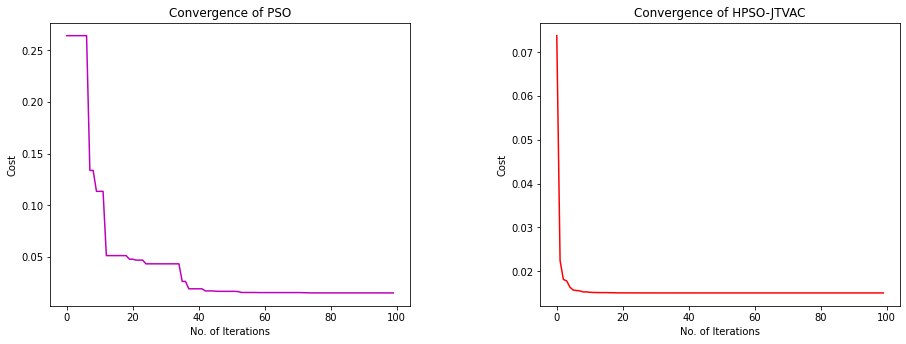

In [ ]:
#Errors
e2 = np.sum(np.abs((actual-best_pos1)/actual)*100)/4
e3 = np.sum(np.abs((actual-best_pos2)/actual)*100)/4
print("Error wrt PSO: {0:.3f} %, \nError wrt HPSO_JTVAC: {1:.3f} %\n".format(e2,e3))

#Plotting convergence curves
pl.cost_comparison(list_loss1,list_loss2)

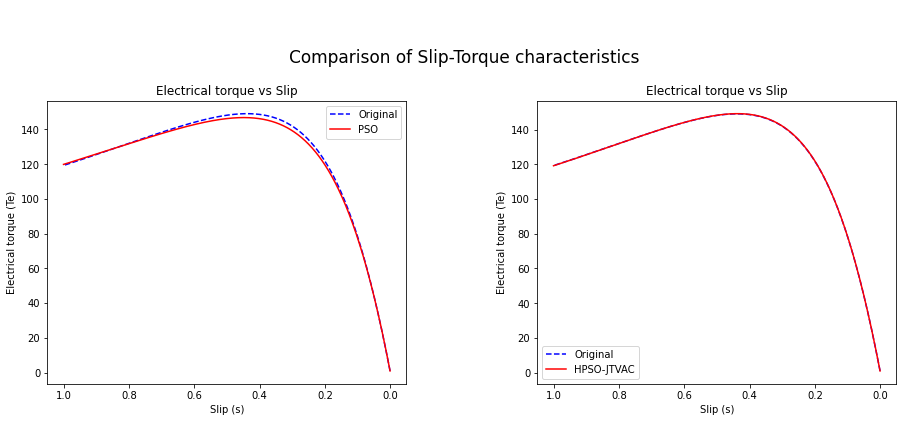

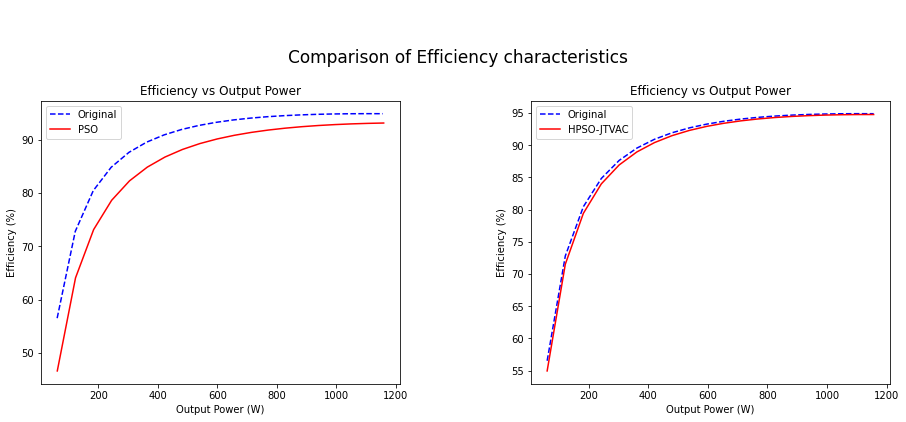

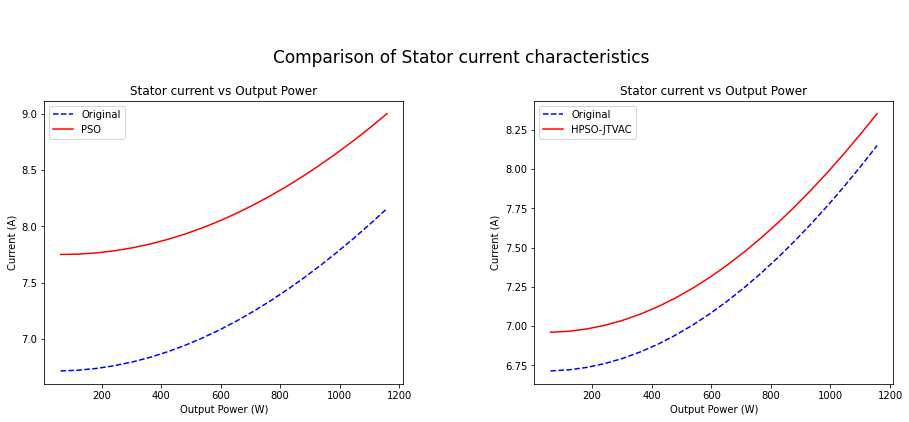

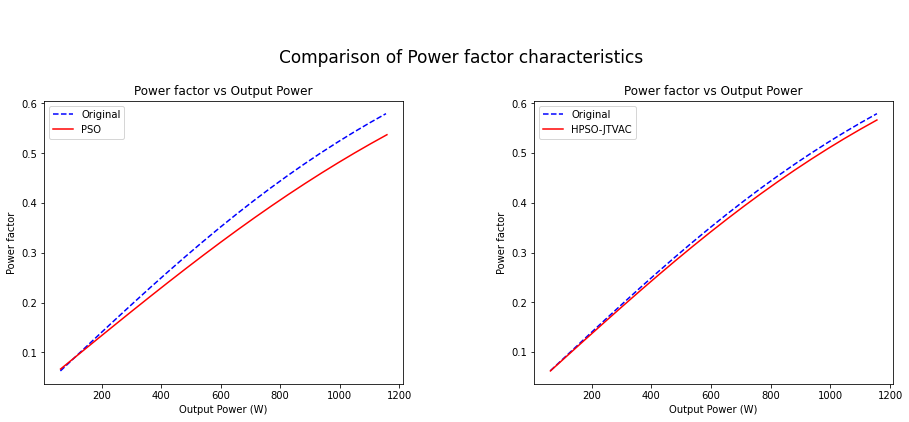

In [ ]:
pl.performance(actual,best_pos1,best_pos2)